# Project 3:Sentiment Analysis of Tweets Using Neural Networks
## Description 
This project aims to build a Sentiment Analysis Neural Network (SANN) using PyTorch to classify tweets into three sentiment categories. As pointed out, there are three types of feedback: positive, negative and neutral. This involves using Word2Vec embeddings (from GloVe) to extract the content of the tweets and translate it to a dimensional space of meaning. In constructing the model structure, the hidden layer with ReLU activation was employed to extract more computational patterns in the feed data. In contrast, the output layer applied softmax to determine metric probabilities of sentiment.

Further objectives include relying on PyTorch’s nn module components; we use nn. Linear for transitioning to the fully connected layers, and nn.CrossEntropyLoss as the classification loss; the Adam optimizer for most efficient updates. In order to increase the speed of batch processing and the generalization of the models considerably, we have used DataLoader. Despite this, it is always good to know how the measurements work; therefore, the last evaluation measures used include Model accuracy, the F1 score, and the confusion matrix.


## Importing of  Libraries

In [1]:
# Data handling libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
# PyTorch libraries for building and training models
import torch  # Main PyTorch library
import torch.nn as nn  # For neural network components
import torch.optim as optim  # For optimization algorithms
from torch.utils.data import DataLoader, TensorDataset  # For data loading and batching
# Scikit-learn for data splitting and evaluation metrics
from sklearn.model_selection import train_test_split  # For splitting data into train/validation sets
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix  # For evaluating model performance
# For encoding labels into numerical format
from sklearn.preprocessing import LabelEncoder  # Converts categorical labels to numerical
# Visualization libraries
import seaborn as sns  # For creating visualizations
import matplotlib.pyplot as plt  # For plotting graphs
# To fetch data from URLs
import requests  # For making HTTP requests to download data

## Step 2: Loading of Data

In [2]:

def load_data(url):
    """Load data from the provided URL."""
    response = requests.get(url)  # Get data from URL
    response.raise_for_status()  # Check for errors
    return [line.strip() for line in response.text.splitlines()]  # Return cleaned lines

# URLs for the datasets
train_texts = load_data('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt')  # Load training texts
train_labels = load_data('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt')  # Load training labels
valid_texts = load_data('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt')  # Load validation texts
valid_labels = load_data('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt')  # Load validation labels
test_texts = load_data('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt')  # Load test texts
test_labels = load_data('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt')  # Load test labels


## Step 3: Label Encoding

In [3]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# Convert texts to lowercase
train_texts = [text.lower() for text in train_texts]
valid_texts = [text.lower() for text in valid_texts]
test_texts = [text.lower() for text in test_texts]


## Steep 4: Load Pre-trained Word2Vec Embeddings

In [4]:
# Load GloVe embeddings
embedding_dict = {}
with open('glove.twitter.27B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector

# Get word embeddings for a text
def get_word_embedding(text, embedding_dict):
    embeddings = [embedding_dict.get(word, np.zeros(50)) for word in text.split()]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(50)

# Create embeddings for train, validation, and test texts
train_embeddings = np.array([get_word_embedding(text, embedding_dict) for text in train_texts])
valid_embeddings = np.array([get_word_embedding(text, embedding_dict) for text in valid_texts])
test_embeddings = np.array([get_word_embedding(text, embedding_dict) for text in test_texts])


# Step 5:Tensor Conversion and DataLoader Creation

In [5]:
# Convert embeddings and labels to tensors
train_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
valid_tensor = torch.tensor(valid_embeddings, dtype=torch.float32)
test_tensor = torch.tensor(test_embeddings, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets and data loaders
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Step 6 :Defining Model  for Neural Network

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the Neural Network Model
class SentimentAnalysisModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentAnalysisModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Cross-validation implementation
def cross_validate(model, embeddings, labels, batch_size=64, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    # Start cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(embeddings)):
        print(f"Fold {fold+1}")

        # Split the data into training and validation
        train_embeddings_fold, val_embeddings_fold = embeddings[train_idx], embeddings[val_idx]
        train_labels_fold, val_labels_fold = labels[train_idx], labels[val_idx]

        # Convert to tensors for each fold
        train_tensor = torch.tensor(train_embeddings_fold, dtype=torch.float32)
        val_tensor = torch.tensor(val_embeddings_fold, dtype=torch.float32)
        train_labels_tensor = torch.tensor(train_labels_fold, dtype=torch.long)
        val_labels_tensor = torch.tensor(val_labels_fold, dtype=torch.long)

        # Create DataLoaders for this fold
        train_dataset = TensorDataset(train_tensor, train_labels_tensor)
        val_dataset = TensorDataset(val_tensor, val_labels_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Initialize the model for this fold
        model = SentimentAnalysisModel(input_dim=50, hidden_dim=128, output_dim=3)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # Training loop for the current fold
        model.train()  # Set model to training mode
        for epoch in range(1):  # Modify the number of epochs as needed
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(targets.numpy())

        # Calculate accuracy for the fold
        accuracy = accuracy_score(all_labels, all_preds)
        fold_accuracies.append(accuracy)
        print(f"Accuracy for fold {fold+1}: {accuracy:.4f}")

    # Calculate and print the average accuracy across all folds
    avg_accuracy = sum(fold_accuracies) / n_splits
    print(f"Average Accuracy across all folds: {avg_accuracy:.4f}")

# Perform cross-validation
cross_validate(SentimentAnalysisModel, train_embeddings, train_labels, batch_size=64, n_splits=5)


Fold 1
Accuracy for fold 1: 0.5682
Fold 2
Accuracy for fold 2: 0.5653
Fold 3
Accuracy for fold 3: 0.5653
Fold 4
Accuracy for fold 4: 0.5746
Fold 5
Accuracy for fold 5: 0.5645
Average Accuracy across all folds: 0.5676


## Step 7:Model Definition and Initialization

In [36]:
epochs = 50
for epoch in range(epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(y_pred, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    
    # Print epoch metrics
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Avg Training Loss: {total_train_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Validation metrics
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    print(f'Epoch [{epoch}/{epochs}], Validation Loss: {total_val_loss / len(valid_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [0/50], Avg Training Loss: 0.8912, Training Accuracy: 0.6524
Epoch [0/50], Validation Loss: 0.9324, Validation Accuracy: 0.6050
Epoch [1/50], Validation Loss: 0.9338, Validation Accuracy: 0.6020
Epoch [2/50], Validation Loss: 0.9309, Validation Accuracy: 0.6015
Epoch [3/50], Validation Loss: 0.9325, Validation Accuracy: 0.6045
Epoch [4/50], Validation Loss: 0.9331, Validation Accuracy: 0.5970
Epoch [5/50], Validation Loss: 0.9337, Validation Accuracy: 0.6015
Epoch [6/50], Validation Loss: 0.9337, Validation Accuracy: 0.6015
Epoch [7/50], Validation Loss: 0.9322, Validation Accuracy: 0.6030
Epoch [8/50], Validation Loss: 0.9356, Validation Accuracy: 0.6060
Epoch [9/50], Validation Loss: 0.9329, Validation Accuracy: 0.6025
Epoch [10/50], Avg Training Loss: 0.8852, Training Accuracy: 0.6605
Epoch [10/50], Validation Loss: 0.9335, Validation Accuracy: 0.6030
Epoch [11/50], Validation Loss: 0.9315, Validation Accuracy: 0.6045
Epoch [12/50], Validation Loss: 0.9323, Validation Accuracy

## Step 7:Training the Model 
### 1.Validation Phase

In [42]:
from sklearn.metrics import f1_score

# Set model to eval mode
model.eval()
correct_test = 0
total_test = 0
y_true = []
y_pred = []

# No gradient calculation during testing
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())  # Move labels to CPU
        y_pred.extend(predicted.cpu().numpy())  # Move preds to CPU

# Calculate accuracy
test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')  # Handle class imbalance
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.5884
Test F1 Score: 0.5847


## Step 8 :Evaluation and Confusion Matrix

Length of y_pred: 12284


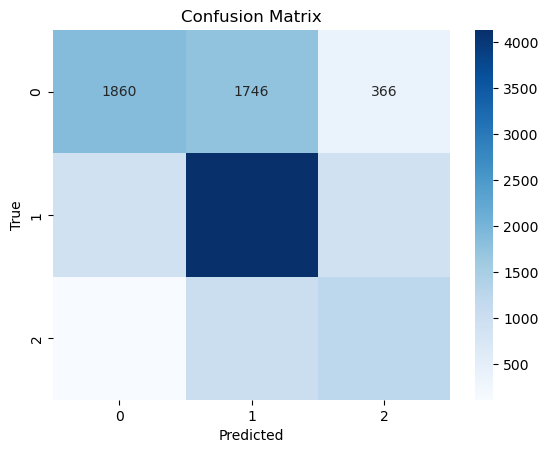

              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3972
           1       0.60      0.70      0.64      5937
           2       0.49      0.52      0.51      2375

    accuracy                           0.59     12284
   macro avg       0.58      0.56      0.56     12284
weighted avg       0.59      0.59      0.58     12284



In [41]:
import numpy as np

model.eval()  # Set the model to evaluation mode
y_pred = []  # List to store predictions

# Loop through the test dataset
with torch.no_grad():  # No need to compute gradients during inference
    for inputs, _ in test_loader:  # Loop through batches of the test set
        outputs = model(inputs)  # Forward pass: get model predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (max value index)
        y_pred.extend(predicted.numpy())  # Append predictions to the list

# Convert to numpy array for consistency
y_pred = np.array(y_pred)

# Check the length of the predictions to make sure they match the length of y_true
print("Length of y_pred:", len(y_pred))  # Should be 12284, the same as y_true

# Now, you can proceed with plotting the confusion matrix and generating the classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)  # Plot heatmap
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()  # Display the confusion matrix plot

# Print classification report for detailed performance metrics
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))  # Precision, recall, F1-score
